<a href="https://colab.research.google.com/github/Rajarshi-Misra/Wavelet-AutoEncoder/blob/main/Copy_of_SOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pywt

In [4]:
import tensorflow as tf
import torch

In [5]:
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [6]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [7]:
num_data = 1000
frac_train = 0.7
frac_test = 0.3
x_train = x_train[0:int(frac_train*num_data)]
x_test = x_test[0:int(frac_test*num_data)]

In [8]:
dimension = x_train.shape[1]
norm_factor = 255.
x_train = x_train.astype('float32')/norm_factor
x_test = x_test.astype('float32')/norm_factor
x_train = np.reshape(x_train, (len(x_train), dimension, dimension, 1))
x_test = np.reshape(x_test, (len(x_test), dimension, dimension, 1))

In [9]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

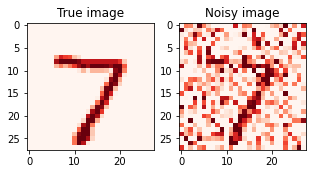

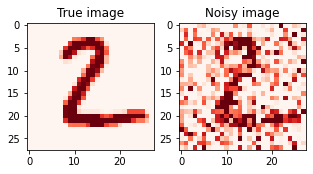

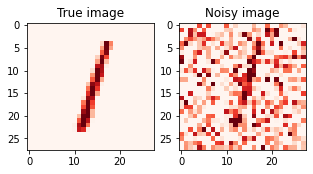

In [10]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(5, 5)
    axes[0].set_title('True image')
    im0 = axes[0].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Noisy image')
    im1 = axes[1].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')

In [26]:
class DWT_downsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, x):
        """
        The following calculations for DWT are inspired from,
        https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
        """
        x1 = x[:, 0::2, 0::2, :] #x(2i−1, 2j−1)
        x2 = x[:, 1::2, 0::2, :] #x(2i, 2j-1)
        x3 = x[:, 0::2, 1::2, :] #x(2i−1, 2j)
        x4 = x[:, 1::2, 1::2, :] #x(2i, 2j)   

        x_LL = x1 + x2 + x3 + x4
        x_LH = -x1 - x3 + x2 + x4
        x_HL = -x1 + x3 - x2 + x4
        x_HH = x1 - x3 - x2 + x4

        return keras.layers.Concatenate(axis=-1)([x_LL, x_LH, x_HL, x_HH])

In [12]:
import keras.backend as K

In [13]:
class IWT_upsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, x):
        """
        The following calculations for DWT are inspired from,
        https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
        """
        x_LL = x[:, :, :, 0:x.shape[3]//4]
        x_LH = x[:, :, :, x.shape[3]//4:x.shape[3]//4*2]
        x_HL = x[:, :, :, x.shape[3]//4*2:x.shape[3]//4*3]
        x_HH = x[:, :, :, x.shape[3]//4*3:]  

        x1 = (x_LL - x_LH - x_HL + x_HH)/4
        x2 = (x_LL - x_LH + x_HL - x_HH)/4
        x3 = (x_LL + x_LH - x_HL - x_HH)/4
        x4 = (x_LL + x_LH + x_HL + x_HH)/4 
        y1 = K.stack([x1,x3], axis=2)
        y2 = K.stack([x2,x4], axis=2)
        shape = K.shape(x)
        return K.reshape(K.concatenate([y1,y2], axis=-1), K.stack([shape[0], shape[1]*2, shape[2]*2, shape[3]//4]))

In [27]:
input_img = keras.Input(shape = (dimension, dimension, 1))
print(input_img.shape)
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(input_img)
print(x.shape)
x = DWT_downsampling()(x)
print(x.shape)

x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
print(x.shape)
encoded = DWT_downsampling()(x)
print(encoded.shape)

(None, 28, 28, 1)
(None, 28, 28, 32)
Tensor("dwt_downsampling_2/strided_slice:0", shape=(None, 14, 14, 32), dtype=float32)
Tensor("dwt_downsampling_2/strided_slice_1:0", shape=(None, 14, 14, 32), dtype=float32)
(None, 14, 14, 128)
(None, 14, 14, 32)
Tensor("dwt_downsampling_3/strided_slice:0", shape=(None, 7, 7, 32), dtype=float32)
Tensor("dwt_downsampling_3/strided_slice_1:0", shape=(None, 7, 7, 32), dtype=float32)
(None, 7, 7, 128)


In [15]:
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(encoded)
print(x.shape)
x = IWT_upsampling()(x)
print(x.shape)
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
print(x.shape)
x = IWT_upsampling()(x)
print(x.shape)
decoded = layers.Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x)
print(decoded.shape)

(None, 7, 7, 32)
(None, 14, 14, 8)
(None, 14, 14, 32)
(None, 28, 28, 8)
(None, 28, 28, 1)


In [16]:
autoencoder = keras.Model(input_img, decoded)

In [17]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 dwt_downsampling (DWT_downs  (None, 14, 14, 128)      0         
 ampling)                                                        
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        36896     
                                                                 
 dwt_downsampling_1 (DWT_dow  (None, 7, 7, 128)        0         
 nsampling)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          36896 

In [18]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [19]:
validation_split = 0.8
history = autoencoder.fit(x_train_noisy, x_train, epochs = 40, batch_size = 20, shuffle = True, validation_split = validation_split)

Epoch 1/40
7/7 [==============================] - 8s 378ms/step - loss: 0.6742 - val_loss: 0.6312
Epoch 2/40
7/7 [==============================] - 2s 304ms/step - loss: 0.5767 - val_loss: 0.5096
Epoch 3/40
7/7 [==============================] - 2s 283ms/step - loss: 0.5052 - val_loss: 0.4748
Epoch 4/40
7/7 [==============================] - 2s 293ms/step - loss: 0.4632 - val_loss: 0.4392
Epoch 5/40
7/7 [==============================] - 2s 298ms/step - loss: 0.4235 - val_loss: 0.3967
Epoch 6/40
7/7 [==============================] - 1s 198ms/step - loss: 0.3746 - val_loss: 0.3455
Epoch 7/40
7/7 [==============================] - 2s 295ms/step - loss: 0.3179 - val_loss: 0.2838
Epoch 8/40
7/7 [==============================] - 2s 294ms/step - loss: 0.2532 - val_loss: 0.2240
Epoch 9/40
7/7 [==============================] - 1s 229ms/step - loss: 0.1971 - val_loss: 0.1772
Epoch 10/40
7/7 [==============================] - 2s 357ms/step - loss: 0.1594 - val_loss: 0.1530
Epoch 11/40
7/7 [==

In [20]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [21]:
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

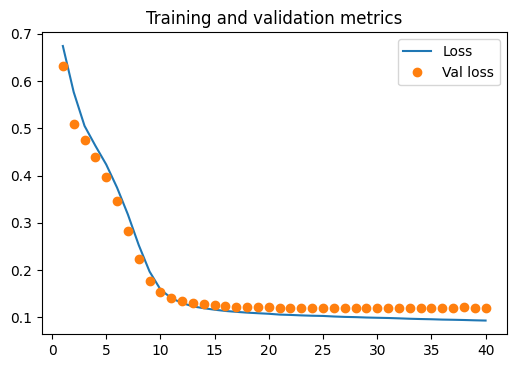

In [22]:
plt.figure(dpi = 100)
plt.plot(epochs, train_loss, label = 'Loss')
plt.plot(epochs, train_val_loss, 'o', label = 'Val loss')
plt.title('Training and validation metrics')
plt.legend()
plt.savefig('history.png')

In [23]:
all_denoised_images = autoencoder.predict(x_test_noisy)

10/10 [==============================] - 1s 36ms/step


In [24]:
test_loss  = autoencoder.evaluate(x_test_noisy, x_test, batch_size = 20)
print(test_loss)

15/15 [==============================] - 0s 26ms/step - loss: 0.1192
0.1192203015089035


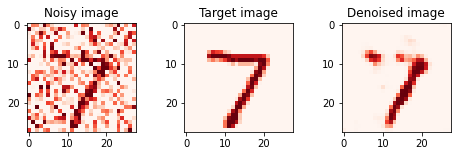

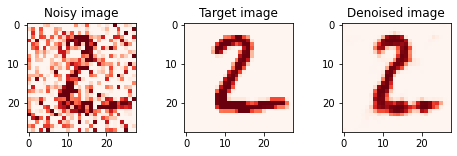

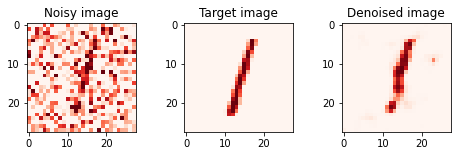

In [25]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(8, 2)
    axes[0].set_title('Noisy image')
    im0 = axes[0].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Target image')
    im1 = axes[1].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[2].set_title('Denoised image')
    im2 = axes[2].imshow(all_denoised_images[i].reshape(dimension, dimension), cmap = 'Reds')
    plt.savefig(f'comparison-{i}.png')